In [2]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=2, threads_per_worker=2,dashboard_address=':8787')

client = Client(cluster)
client

/mnt/meom/workdir/albert/anaconda2/envs/erika/lib/python3.6/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:45411 Dashboard: http://127.0.0.1:33683/status,Cluster Workers: 2 Cores: 4 Memory: 35.01 GB


In [3]:
## Path for modules

import sys

import numpy as np
import xarray as xr

from netCDF4 import Dataset

sys.path.insert(0,"/mnt/meom/workdir/henelle/Notebooks/git/xscale")
import xscale
import xscale.spectral.fft as xfft

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import numpy.ma as ma

import matplotlib.cm as mplcm
import matplotlib.colors as colors
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import date, datetime
from xhistogram.xarray import histogram

import pandas as pd

import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

### Modified fct

def plot_histo_space(chunkx,chunky,curlT0,curl00,strainT0,strain00,navlon,navlat):
    
    box=(-31,-28,33,36)
    domain=(box[0]<navlon)*(navlon<box[1])*(box[2]<navlat)*(navlat<box[3])
    where=np.where(domain)

    jmin = where[0][0]
    jmax = where[0][-1]
    imin = where[1][0]
    imax = where[1][-1]

    strainT0_filtbox = strainT0_filt[:,jmin:jmax+1,imin:imax+1]
    strain00_filtbox = strain00_filt[:,jmin:jmax+1,imin:imax+1]
    curlT0_filtbox = curlT0_filt[:,jmin:jmax+1,imin:imax+1]
    curl00_filtbox = curl00_filt[:,jmin:jmax+1,imin:imax+1]

    sbins = np.arange(0.0,0.5, 0.025)
    cbins = np.arange(-0.5,0.5, 0.025)

    hist_JAS_strain00_filtbox = histogram(strain00_filtbox,bins=[sbins])
    hist_JAS_strainT0_filtbox = histogram(strainT0_filtbox,bins=[sbins])
    hist_JAS_curl00_filtbox   = histogram(curl00_filtbox,bins=[cbins])
    hist_JAS_curlT0_filtbox   = histogram(curlT0_filtbox,bins=[cbins])

    log_hist_JAS_strain00 = np.log10(hist_JAS_strain00_filtbox)
    log_hist_JAS_strainT0 = np.log10(hist_JAS_strainT0_filtbox)
    log_hist_JAS_curl00   = np.log10(hist_JAS_curl00_filtbox)
    log_hist_JAS_curlT0   = np.log10(hist_JAS_curlT0_filtbox)

    ### Add weights ###

    fig = plt.figure(figsize=(14,20))
    gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[2]) 
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
   
  
    # Adding histograms
    log_hist_JAS_strain00.plot(ax=ax1,label='no tide',lw=3.0,color='lightseagreen')
    log_hist_JAS_strainT0.plot(ax=ax1,label='tide',lw=3.0,linestyle='-.',color='darkred')
    ax1.set_xlabel('24h filtered '+'curl/f',size=16)
    ax1.set_ylabel('')
    ax1.tick_params(labelsize=15)

    log_hist_JAS_curl00.plot(ax=ax2,label='no tide',lw=3.0,color='lightseagreen')
    log_hist_JAS_curlT0.plot(ax=ax2,label='tide',lw=3.0,linestyle='-.',color='darkred')
    ax2.set_xlabel('24h filtered '+'strain/f',size=16)
    ax2.set_ylabel('')
    ax2.tick_params(labelsize=15)
    
    # Designing legend
    plt.draw()
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center',frameon=True,shadow=True,fontsize=16,bbox_to_anchor=(0.5, 0.07, 0.5, 0.5),
               markerscale=5.0,framealpha=0.8,edgecolor='black',facecolor='white')
    

    ax1.set_xlim((-0.5,0.5))
    ax2.set_xlim((0,0.5))

def plot_surf(data1,data2,vmin,vmax,var_title_data1,var_title_data2,cmap,extend):
    fig = plt.figure(figsize=(14,20))
    gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[2]) 
    
    
    ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())#221
    ax2 = fig.add_subplot(gs[0, 1],projection=ccrs.PlateCarree())#222
    
    # Adjust subplots
    plt.subplots_adjust(hspace=0.0,wspace=0.1)
    
    norm_fld_data1 = colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
    
    pcolor1 = ax1.pcolormesh(lon,lat,data1,cmap=cmap,vmin=vmin,vmax=vmax,norm = norm_fld_data1)
    pcolor2 = ax2.pcolormesh(lon,lat,data2,cmap=cmap,vmin=vmin,vmax=vmax,norm = norm_fld_data1)
    
    # Add the Azores
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor='dimgray')
    ax1.add_feature(land)
    ax2.add_feature(land)
    
    
    # Colorbar ax1
    cax1,kw1   = mpl.colorbar.make_axes(ax1,location='bottom',pad=0.05,shrink=0.95)
    out1       = fig.colorbar(pcolor1,cax=cax1,extend=extend,**kw1)
    out1.set_label(var_title_data1,size=16)
    out1.ax.tick_params(labelsize=16)
    xticks_ax1 = np.linspace(vmin,vmax,num=5)
    out1.set_ticks(xticks_ax1)
    
    # Colorbar ax2
    cax2,kw2   = mpl.colorbar.make_axes(ax2,location='bottom',pad=0.05,shrink=0.95)
    out2       = fig.colorbar(pcolor1,cax=cax2,extend=extend,**kw2)
    out2.set_label(var_title_data2,size=16)
    out2.ax.tick_params(labelsize=16)
    xticks_ax2 = np.linspace(vmin,vmax,num=5)
    out2.set_ticks(xticks_ax2)
    
    # Grid    
    gl1            = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,lw=1,color='gray',alpha=0.8, ls='--')
    gl1.xformatter = LONGITUDE_FORMATTER
    gl1.yformatter = LATITUDE_FORMATTER
    gl1.xlabel_style = {'size': 13, 'color': 'dimgray'}
    gl1.ylabel_style = {'size': 13, 'color': 'dimgray'}
    gl1.xlabels_top = False
    gl1.ylabels_right = False
    gl2            = ax2.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,lw=1,color='gray',alpha=0.8, ls='--')
    gl2.xformatter = LONGITUDE_FORMATTER
    gl2.yformatter = LATITUDE_FORMATTER
    gl2.xlabel_style = {'size': 13, 'color': 'dimgray'}
    gl2.ylabel_style = {'size': 13, 'color': 'dimgray'}
    gl2.xlabels_top = False
    gl2.ylabels_right = False
    gl2.ylabels_left = False
    
    # Adjusting axes
    ax1.set_xlim((-36, -26))
    ax1.set_ylim((25, 40))
    ax2.set_xlim((-36, -26))
    ax2.set_ylim((25, 40))

In [4]:
def curl(u,v,e1v,e2u,ff):
    '''
    This routine computes the relative vorticity from 2D fields of horizontal velocities and the spatial Coriolis parameter.
    '''
    #Computation of dy(u)
    fe2u=1/e2u
    fse2u=fe2u.squeeze()
    dyu=(u.shift(y=-1) - u)*fse2u
    #Computation of dx(v)
    fe1v=1/e1v
    fse1v=fe1v.squeeze()
    dxv=(v.shift(x=-1) - v)*fse1v
    #Projection on the grid T
    dxvt=0.5*(dxv.shift(y=-1)+dxv)
    dyut=0.5*(dyu.shift(x=-1)+dyu)
    #Computation of the vorticity divided by f
    fff=1/ff
    curl=(dxvt-dyut)*fff
    return curl

In [5]:
def strain(u,v,e1u,e1v,e2u,e2v,ff):
    '''
    This routine computes the relative vorticity from 2D fields of horizontal velocities and the spatial Coriolis parameter.
    '''
    #Computation of dy(u)
    fe2u=1/e2u
    fse2u=fe2u.squeeze()
    dyu=(u.shift(y=-1) - u)*fse2u
    #Computation of dx(v)
    fe1v=1/e1v
    fse1v=fe1v.squeeze()
    dxv=(v.shift(x=-1) - v)*fse1v
    #Computation of dy(v)
    fe2v=1/e2v
    fse2v=fe2v.squeeze()
    dyv=(v.shift(y=-1) - v)*fse2v
    #Computation of dx(u)
    fe1u=1/e1u
    fse1u=fe1u.squeeze()
    dxu=(u.shift(x=-1) - u)*fse1u
    #Projection on the grid T
    dxvt=0.5*(dxv.shift(y=-1)+dxv)
    dyut=0.5*(dyu.shift(x=-1)+dyu)
    dxut=0.5*(dxu.shift(x=-1)+dxu)
    dyvt=0.5*(dyv.shift(y=-1)+dyv)
    #Computation of the strain divided by f
    fff=1/ff
    strain=np.sqrt( (dyut+dxvt)*(dyut+dxvt) + (dxut-dyvt)*(dxut-dyvt) ) *fff
    return strain

In [6]:
## Dataset : grid files and one example of U and V for test


# Opening grid files

dirgrid='/mnt/meom/workdir/alberta/eNATL60/eNATL60-I/'
gridfile=dirgrid+'mesh_hgr_eNATL60ACO_3.6.nc'
dsgrid=xr.open_dataset(gridfile,chunks={'x':200,'y':200})

e1u=dsgrid.e1u
e1v=dsgrid.e1v
e2u=dsgrid.e2u
e2v=dsgrid.e2v
ff=dsgrid.ff



# Opening u & v grid files
# With tide

dirvarT0='/mnt/meom/workdir/alberta/eNATL60/eNATL60-BLBT02-S/1h/ACO/'
ufileT0=dirvarT0+'eNATL60ACO-BLBT02_y2009m*.1h_vozocrtx10m.nc' # JAS
vfileT0=dirvarT0+'eNATL60ACO-BLBT02_y2009m*.1h_vomecrty10m.nc' # JAS
#ufileT0=dirvarT0+'eNATL60ACO-BLBT02_y2009m07d07.1h_vozocrtx10m.nc'
#vfileT0=dirvarT0+'eNATL60ACO-BLBT02_y2009m07d07.1h_vomecrty10m.nc'
dsuT0=xr.open_mfdataset(ufileT0,combine='by_coords',parallel=True,chunks={'x':200,'y':200})
dsvT0=xr.open_mfdataset(vfileT0,combine='by_coords',parallel=True,chunks={'x':200,'y':200})
#dsuT0=xr.open_dataset(ufileT0,chunks={'x':200,'y':200})
#dsvT0=xr.open_dataset(vfileT0,chunks={'x':200,'y':200})
uT0=dsuT0.vozocrtx
vT0=dsvT0.vomecrty # [0] innan; changer
lon=dsuT0.nav_lon
lat=dsuT0.nav_lat
print(uT0.shape)

# Without tide

dirvar00='/mnt/meom/workdir/alberta/eNATL60/eNATL60-BLB002-S/1h/ACO/'
ufile00=dirvar00+'eNATL60ACO-BLB002_y2009m*.1h_vozocrtx10m.nc' # JAS
vfile00=dirvar00+'eNATL60ACO-BLB002_y2009m*.1h_vomecrty10m.nc' # JAS
#ufile00=dirvar00+'eNATL60ACO-BLB002_y2009m07d07.1h_vozocrtx10m.nc'
#vfile00=dirvar00+'eNATL60ACO-BLB002_y2009m07d07.1h_vomecrty10m.nc'
dsu00=xr.open_mfdataset(ufile00,combine='by_coords',parallel=True,chunks={'x':200,'y':200})
dsv00=xr.open_mfdataset(vfile00,combine='by_coords',parallel=True,chunks={'x':200,'y':200})
#dsu00=xr.open_dataset(ufile00,chunks={'x':200,'y':200})
#dsv00=xr.open_dataset(vfile00,chunks={'x':200,'y':200})
u00=dsu00.vozocrtx
v00=dsv00.vomecrty

(2208, 1, 1191, 781)


In [7]:
lon.shape

(1191, 781)

In [8]:
# Filtering of u & v

T=2*np.pi/(1E-4) # Coriolis period

wuT0 = uT0.window
wuT0.set(n=48,dim='time_counter', cutoff=2*T)
uT0_filt = wuT0.convolve()

wu00 = u00.window
wu00.set(n=48,dim='time_counter', cutoff=2*T)
u00_filt = wu00.convolve()

wvT0 = vT0.window
wvT0.set(n=48,dim='time_counter', cutoff=2*T)
vT0_filt = wvT0.convolve()

wv00 = v00.window
wv00.set(n=48,dim='time_counter', cutoff=2*T)
v00_filt = wv00.convolve()


In [9]:
### Compute curl and strain with python

curlT0_filt   = curl(uT0_filt,vT0_filt,e1v,e2u,ff)
curl00_filt   = curl(u00_filt,v00_filt,e1v,e2u,ff)
strainT0_filt = strain(uT0_filt,vT0_filt,e1u,e1v,e2u,e2v,ff)
strain00_filt = strain(u00_filt,v00_filt,e1u,e1v,e2u,e2v,ff)


In [10]:
box=(-31,-28,33,36)
domain=(box[0]<lon)*(lon<box[1])*(box[2]<lat)*(lat<box[3])
where=np.where(domain)

In [11]:
jmin = where[0][0]
jmax = where[0][-1]
imin = where[1][0]
imax = where[1][-1]

In [12]:
print(imin,imax,jmin,jmax)

384 563 668 883


In [13]:
strainT0_filtbox = strainT0_filt.squeeze()[:,jmin:jmax+1,imin:imax+1]
strain00_filtbox = strain00_filt.squeeze()[:,jmin:jmax+1,imin:imax+1]
curlT0_filtbox   = curlT0_filt.squeeze()[:,jmin:jmax+1,imin:imax+1]
curl00_filtbox   = curl00_filt.squeeze()[:,jmin:jmax+1,imin:imax+1]

In [12]:
#weights_curlT0_filt   = np.ones_like(curlT0_filtbox)/float(len(curlT0_filtbox))
#weights_curl00_filt   = np.ones_like(curl00_filtbox)/float(len(curl00_filtbox))
#weights_strainT0_filt = np.ones_like(strainT0_filtbox)/float(len(strainT0_filtbox))
#weights_strain00_filt = np.ones_like(strain00_filtbox)/float(len(strain00_filtbox))

In [14]:
sbins = np.arange(0.0,0.5, 0.025)
cbins = np.arange(-0.5,0.5, 0.025)

In [16]:
weights_curlT0_filt   = xr.ones_like(curlT0_filtbox)/float(len(curlT0_filtbox))
weights_curl00_filt   = xr.ones_like(curl00_filtbox)/float(len(curl00_filtbox))
weights_strainT0_filt = xr.ones_like(strainT0_filtbox)/float(len(strainT0_filtbox))
weights_strain00_filt = xr.ones_like(strain00_filtbox)/float(len(strain00_filtbox))

In [28]:
strain00_filtbox.name ='strain00'
strainT0_filtbox.name ='strain00'
curl00_filtbox.name ='strain00'
curlT0_filtbox.name ='strain00'

In [29]:
weights_strain00_filt.name ='weights_strain00'
weights_strainT0_filt.name ='weights_strainT0'
weights_curl00_filt.name ='weights_curl00'
weights_curlT0_filt.name ='weights_curlT0'


In [30]:
hist_JAS_strain00_filtbox = histogram(strain00_filtbox,bins=[sbins], weights=weights_strain00_filt)
hist_JAS_strainT0_filtbox = histogram(strainT0_filtbox,bins=[sbins], weights=weights_strainT0_filt)
hist_JAS_curl00_filtbox   = histogram(curl00_filtbox,bins=[cbins], weights=weights_curl00_filt)
hist_JAS_curlT0_filtbox   = histogram(curlT0_filtbox,bins=[cbins], weights=weights_curlT0_filt)

In [31]:
log_hist_JAS_strain00 = np.log10(hist_JAS_strain00_filtbox)
log_hist_JAS_strainT0 = np.log10(hist_JAS_strainT0_filtbox)
log_hist_JAS_curl00   = np.log10(hist_JAS_curl00_filtbox)
log_hist_JAS_curlT0   = np.log10(hist_JAS_curlT0_filtbox)


In [33]:
log_hist_JAS_strain00.shape

(19,)

In [34]:
np.savez('log_hist_JAS_strain00.npz',log_hist_JAS_strain00 = log_hist_JAS_strain00)
np.savez('log_hist_JAS_strainT0.npz',log_hist_JAS_strainT0 = log_hist_JAS_strainT0)
np.savez('log_hist_JAS_curl00.npz',log_hist_JAS_curl00 = log_hist_JAS_curl00)
np.savez('log_hist_JAS_curlT0.npz',log_hist_JAS_curlT0 = log_hist_JAS_curlT0)

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

(0, 0.5)

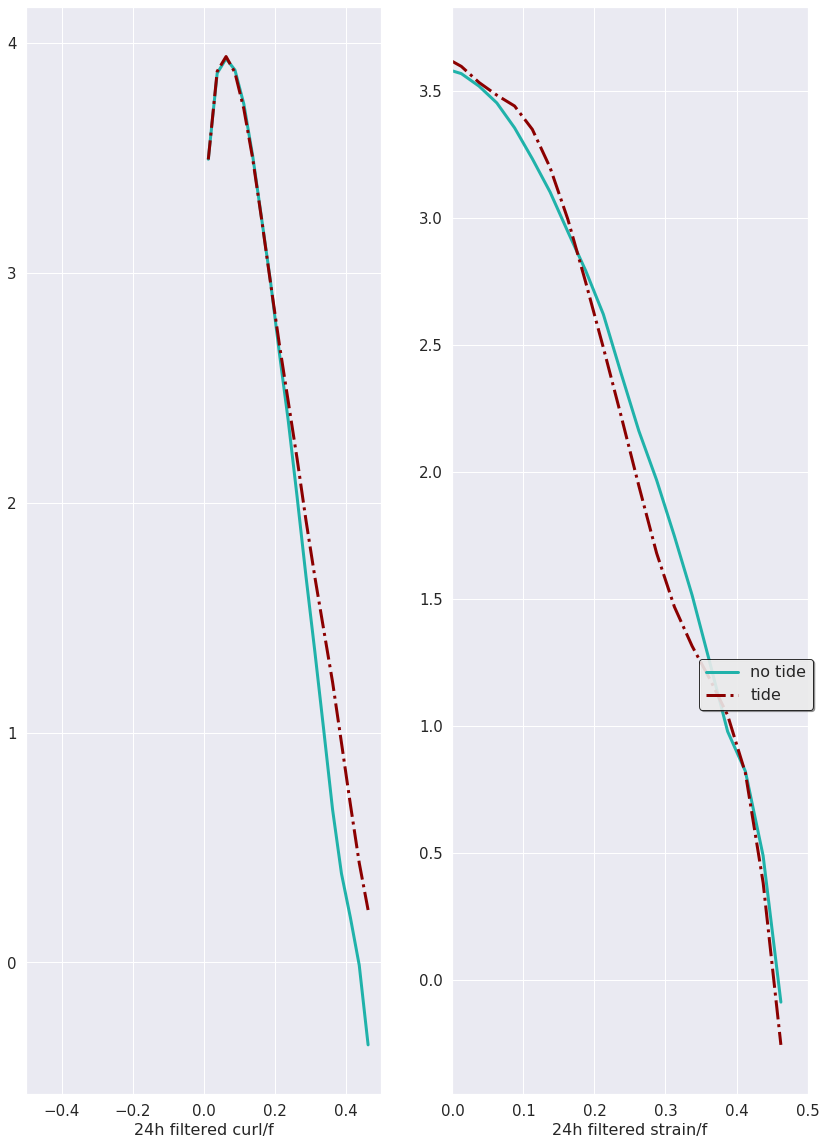

In [32]:
fig = plt.figure(figsize=(14,20))
gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[2]) 

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])


# Adding histograms
log_hist_JAS_strain00.plot(ax=ax1,label='no tide',lw=3.0,color='lightseagreen')
log_hist_JAS_strainT0.plot(ax=ax1,label='tide',lw=3.0,linestyle='-.',color='darkred')
ax1.set_xlabel('24h filtered '+'strain/f',size=16)
ax1.set_ylabel('')
ax1.tick_params(labelsize=15)

log_hist_JAS_curl00.plot(ax=ax2,label='no tide',lw=3.0,color='lightseagreen')
log_hist_JAS_curlT0.plot(ax=ax2,label='tide',lw=3.0,linestyle='-.',color='darkred')
ax2.set_xlabel('24h filtered '+'strain/f',size=16)
ax2.set_ylabel('')
ax2.tick_params(labelsize=15)

# Designing legend
plt.draw()
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center',frameon=True,shadow=True,fontsize=16,bbox_to_anchor=(0.5, 0.07, 0.5, 0.5),
           markerscale=5.0,framealpha=0.8,edgecolor='black',facecolor='white')


ax1.set_xlim((-0.5,0.5))
ax2.set_xlim((0,0.5))